# Loading Libraries and helper files

In [225]:
import os
from pathlib import Path
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from scipy.stats import logistic
from scipy.stats import norm
from stargazer.stargazer import Stargazer
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss
from plotnine import *

from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

warnings.filterwarnings("ignore")

In [226]:
path = Path(os.getcwd())
tech_prep = os.path.join(str(path), "utils/")
sys.path.append(tech_prep)
from py_helper_functions import *

# 1. Data Loading, Exploration, and Basic Filtering

In [227]:
# Loading data and checking
main_df = pd.read_csv('https://osf.io/4ay9x/download')

In [228]:
main_df.shape

(149316, 23)

### Filtering for my chosen occupation: Eduaction Occupations

In [229]:
df = main_df.loc[main_df['occ2012'].isin([2200, 2300, 2310, 2320, 2330, 2340, 2400, 2430, 2440, 2540, 2550])]
df.shape

(9981, 23)

In [230]:
# Checking missing values to see if I should correct/fill the dataset

missing_values = df.isnull().sum()

print("Missing values in each column:")
print(missing_values)

# No missing values in important/chosen variables

Missing values in each column:
Unnamed: 0       0
hhid             0
intmonth         0
stfips           0
weight           0
earnwke          0
uhours           0
grade92          0
race             0
ethnic        9202
age              0
sex              0
marital          0
ownchild         0
chldpres         0
prcitshp         0
state            0
ind02            0
occ2012          0
class            0
unionmme         0
unioncov      3733
lfsr94           0
dtype: int64


In [231]:
df.describe()

,Unnamed: 0,hhid,weight,earnwke,uhours,grade92,race,ethnic,age,sex,marital,ownchild,chldpres,occ2012
count,9981.000000,9.981000e+03,9981.000000,9981.000000,9981.000000,9981.000000,9981.000000,779.000000,9981.000000,9981.000000,9981.000000,9981.000000,9981.000000,9981.000000
mean,156836.258992,4.451023e+14,2263.007325,935.652575,38.321811,42.961928,1.345456,2.658537,42.000902,1.755335,2.866847,0.780683,2.109708,2333.405470
std,92829.912325,3.217686e+14,1278.307226,585.607374,10.892425,1.816246,1.290666,2.437172,12.002275,0.429910,2.595665,1.081402,3.227588,95.613067
min,15.000000,8.171510e+09,53.232500,0.230000,1.000000,31.000000,1.000000,1.000000,16.000000,1.000000,1.000000,0.000000,0.000000,2200.000000
25%,76232.000000,1.333500e+14,1144.527300,500.000000,36.000000,43.000000,1.000000,1.000000,32.000000,2.000000,1.000000,0.000000,0.000000,2310.000000
50%,154275.000000,4.089016e+14,2528.657200,865.000000,40.000000,43.000000,1.000000,1.000000,42.000000,2.000000,1.000000,0.000000,0.000000,2310.000000
75%,238782.000000,7.250320e+14,3239.709400,1222.220000,40.000000,44.000000,1.000000,4.000000,52.000000,2.000000,5.000000,2.000000,3.000000,2330.000000
max,317003.000000,9.999605e+14,24595.832400,2884.610000,99.000000,46.000000,23.000000,8.000000,64.000000,2.000000,7.000000,9.000000,15.000000,2550.000000


In [232]:
# Creating our target variable earnings per hour 'eph' and log of the same 'lneph'

df['eph'] = df['earnwke'] / df['uhours']
df['lneph'] = np.log(df['uhours'])

df['eph'].describe()

count    9981.000000
mean       24.406499
std        19.775815
min         0.004107
25%        14.423000
50%        21.250000
75%        30.000000
max      1076.920000
Name: eph, dtype: float64

#### As you can see the minimum  is 0.004, so there is an error in the data as for a 40 hour work week the pay would be 0.16, which is impossible. I will be removing values less than 7.5 Dollars as that was the minimum hourly wage in 2013 for US

In [233]:
# Basic filtering for working age and cleaner data 

df = df.loc[(df['age'] >= 18) # Filtering for at least 18 years of age
             & (df['earnwke'] > 0) # Filtering for more than 0 wage
             & (df['eph'] > 7.5)
                ]                     
df.shape

(9600, 25)

## 2. Exploring chosen predictor variables
    1. Education level
    2. Age
    3. Gender
    4. Married
    5. has children
    6. Union
    7. Employment type
    8. Private or Public
    9. Race

In [234]:
# Checking what our school teachers education distribution

freq = df.groupby("grade92").agg(frequency=("grade92", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
grade92,,,
31,2,0.021,0.021
32,1,0.010,0.031
33,2,0.021,0.052
34,6,0.062,0.114
35,7,0.073,0.187
36,6,0.062,0.249
37,15,0.156,0.405
38,11,0.115,0.520
39,585,6.094,6.614


In [235]:
# Checking what our school teachers gender distribution

freq = df.groupby("sex").agg(frequency=("sex", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
sex,,,
1,2371,24.698,24.698
2,7229,75.302,100.000


In [236]:
# Checking what our school teachers marital status distribution

freq = df.groupby("marital").agg(frequency=("marital", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
marital,,,
1,6218,64.771,64.771
2,48,0.500,65.271
3,92,0.958,66.229
4,115,1.198,67.427
5,847,8.823,76.250
6,139,1.448,77.698
7,2141,22.302,100.000


In [237]:
# Checking what our school teachers dependants(children) distribution

freq = df.groupby("ownchild").agg(frequency=("ownchild", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
ownchild,,,
0,5519,57.490,57.490
1,1637,17.052,74.542
2,1678,17.479,92.021
3,587,6.115,98.136
4,138,1.438,99.574
5,29,0.302,99.876
6,7,0.073,99.949
7,4,0.042,99.991
9,1,0.010,100.001


In [238]:
# Checking what our school teachers union membership distribution

freq = df.groupby("unionmme").agg(frequency=("unionmme", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
unionmme,,,
No,5921,61.677,61.677
Yes,3679,38.323,100.000


In [239]:
# Checking what our school teachers employment distribution

freq = df.groupby("lfsr94").agg(frequency=("lfsr94", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
lfsr94,,,
Employed-Absent,850,8.854,8.854
Employed-At Work,8750,91.146,100.000


In [240]:
# Checking what our school teachers sector distribution

freq = df.groupby("class").agg(frequency=("class", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
class,,,
Government - Federal,134,1.396,1.396
Government - Local,4291,44.698,46.094
Government - State,2092,21.792,67.886
"Private, For Profit",1912,19.917,87.803
"Private, Nonprofit",1171,12.198,100.001


In [241]:
# Checking what our school teachers sector distribution

freq = df.groupby("race").agg(frequency=("race", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
race,,,
1,8206,85.479,85.479
2,786,8.188,93.667
3,56,0.583,94.250
4,400,4.167,98.417
5,31,0.323,98.740
6,22,0.229,98.969
7,33,0.344,99.313
8,20,0.208,99.521
9,7,0.073,99.594


_________________________________

## 3. Feature Engineering

Creating binary variables from categorical values from our chosen variables

In [242]:
# Creating Education variables
df['HS_GED'] = (df['grade92'] == 39).astype(int) # Associate degree (Vocational/occupational)
df['college_unfin'] = (df['grade92'] == 40).astype(int) # Associate degree (Vocational/occupational)
df['AD_V'] = (df['grade92'] == 41).astype(int) # Associate degree (Vocational/occupational)
df['AD_AP'] = (df['grade92'] == 42).astype(int) # Associate degree (Academic Program)
df['BD'] = (df['grade92'] == 43).astype(int) # Bachelor's degree (e.g.BA,AB,BS)
df['MD'] = (df['grade92'] == 44).astype(int) # Master's degree (e.g.MA,MS,MEng,Med,MSW,MBA) 
df['PD'] = (df['grade92'] == 45).astype(int) # Professional degree (e.g.MD,DDS,DVM,LLB,JD)
df['PhD'] = (df['grade92'] == 46).astype(int) # Doctorate degree(e.g.PhD,EdD)



# Creating age squared variable
df["agesq"] = df["age"] ** 2




# Creating female variable
df['female'] = np.where(df['sex'] == 2, '1', '0') .astype(int)

In [243]:
# Creating dummy variables for marital status
# Created 3 variables by grouping each categorical value that made sense
df['married'] = np.where(df['marital'] <=2, '1', '0').astype(int)
df['separated'] = np.where((df['marital'] >= 3) & (df['marital'] <= 6), '1', '0').astype(int)
df['never_married'] = np.where(df['marital'] == 7, '1', '0').astype(int)



# Creating dummy variables for employment category
df['emp_work']   = (df['lfsr94'] == "Employed-At Work").astype(int).astype(int)
df['emp_absent'] = (df['lfsr94'] == "Employed-Absent").astype(int).astype(int)




# Creating dummy variable for union membership
# Created 1 variable for Yes (1) or No (0)
df['is_union_member'] = np.where(df['unionmme'] == 'Yes', '1', '0').astype(int)

In [244]:
# Creating dummy variables for class/sector of employment

df['gov_fed_empl']      = np.where(df['class'] == 'Government - Federal', '1', '0').astype(int)
df['gov_local_empl']    = np.where(df['class'] == 'Government - Local', '1', '0').astype(int)
df['gov_state_empl']    = np.where(df['class'] == 'Government - State', '1', '0').astype(int)
df['priv_prof_empl']    = np.where(df['class'] == 'Private, For Profit', '1', '0').astype(int)
df['priv_nonprof_empl'] = np.where(df['class'] == 'Private, Nonprofit', '1', '0').astype(int)



# Creating dummy variables for race
df['white_person'] = np.where(df['race'] == 1, '1', '0').astype(int)
df['non_white_person'] = np.where(df['race'] > 1 , '1', '0').astype(int)



# Creating dummy variables for citizenship
df['us_native'] = np.where(df['prcitshp'] == 'Native, Born In US', '1', '0').astype(int)
df['us_native_parents'] = np.where(df['prcitshp'] == 'Native, Born Abroad Of US Parent(s)', '1', '0').astype(int)
df['us_native_terr'] = np.where(df['prcitshp'] == 'Native, Born in PR or US Outlying Area', '1', '0').astype(int)
df['foreign_us'] = np.where(df['prcitshp'] == 'Foreign Born, US Cit By Naturalization', '1', '0').astype(int)
df['foreign_nonus'] = np.where(df['prcitshp'] == 'Foreign Born, Not a US Citizen', '1', '0').astype(int)


## Descriptive statistics

In [245]:
summary_i = df[['eph','age','female',"HS_GED","college_unfin","AD_V", "AD_AP", "BD", "MD", "PD", "PhD",
                "married","separated","never_married", "ownchild", "is_union_member","emp_work","emp_absent",
                "gov_fed_empl", "gov_local_empl" , "gov_state_empl","priv_prof_empl","priv_nonprof_empl",
                "white_person","non_white_person",
                "us_native", "us_native_parents","us_native_terr","foreign_us","foreign_nonus"]].describe().round(3).T


summary = summary_i.rename(
    columns={
        "count": "Observations",
        "mean": "Mean",
        "std": "Standard Deviation",
        "25%": "25th Percentile",
        "50%": "Median",
        "75%": "75th Percentile",
        "max": "Maximum",
        "min": "Minimum",
    })
summary

,Observations,Mean,Standard Deviation,Minimum,25th Percentile,Median,75th Percentile,Maximum
eph,9600.0,25.134,19.812,7.517,15.0,21.634,30.288,1076.92
age,9600.0,42.232,11.833,18.000,32.0,42.000,52.000,64.00
female,9600.0,0.753,0.431,0.000,1.0,1.000,1.000,1.00
HS_GED,9600.0,0.061,0.239,0.000,0.0,0.000,0.000,1.00
college_unfin,9600.0,0.071,0.256,0.000,0.0,0.000,0.000,1.00
AD_V,9600.0,0.017,0.130,0.000,0.0,0.000,0.000,1.00
AD_AP,9600.0,0.040,0.196,0.000,0.0,0.000,0.000,1.00
BD,9600.0,0.350,0.477,0.000,0.0,0.000,1.000,1.00
MD,9600.0,0.373,0.484,0.000,0.0,0.000,1.000,1.00
PD,9600.0,0.017,0.131,0.000,0.0,0.000,0.000,1.00


# 4. Graphs 
### Target Variable: Log transformation or not?

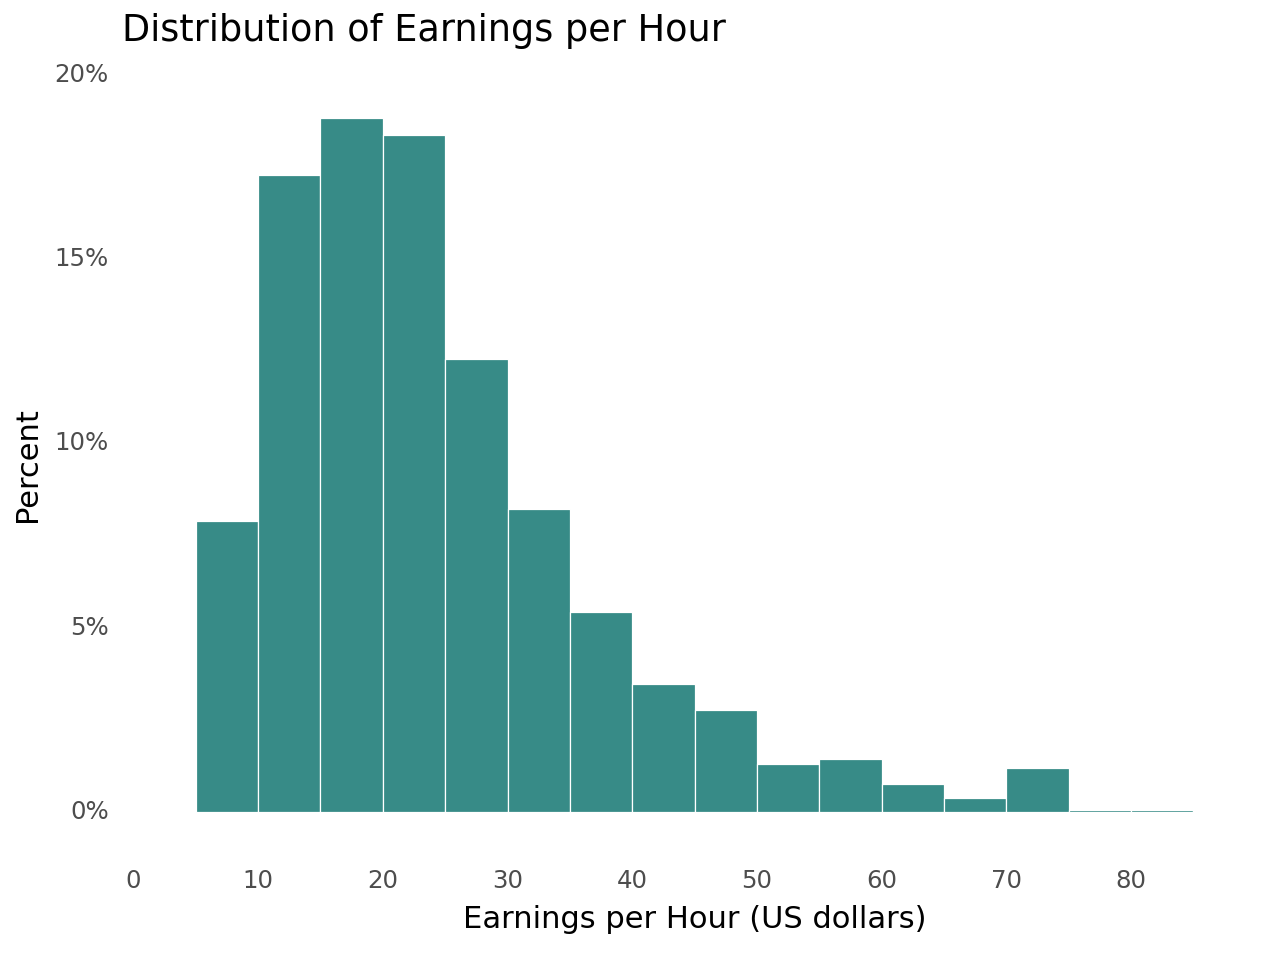

<Figure Size: (640 x 480)>

In [246]:
# Checking distribution for Earnings per Hour

ggplot(df, aes(x="eph")) + geom_histogram(
    aes(y="(stat(count))/sum(stat(count))"),
    binwidth=5,
    boundary=0,
    color="white",
    fill='#056F69',
    size=0.25,
    alpha=0.8,
    show_legend=False,
    na_rm=True,) \
+ coord_cartesian(xlim=(0,90)) \
+ labs(x="Earnings per Hour (US dollars)", y="Percent", title="Distribution of Earnings per Hour") \
+ theme_minimal() + expand_limits(x=0.01, y=0.01) \
+ scale_y_continuous(expand=(0.01, 0.01), labels=percent_format()) \
+ scale_x_continuous(expand=(0.01, 0.01), breaks=seq(0,90,10))\
+ theme(panel_grid_major=element_blank(), panel_grid_minor=element_blank())

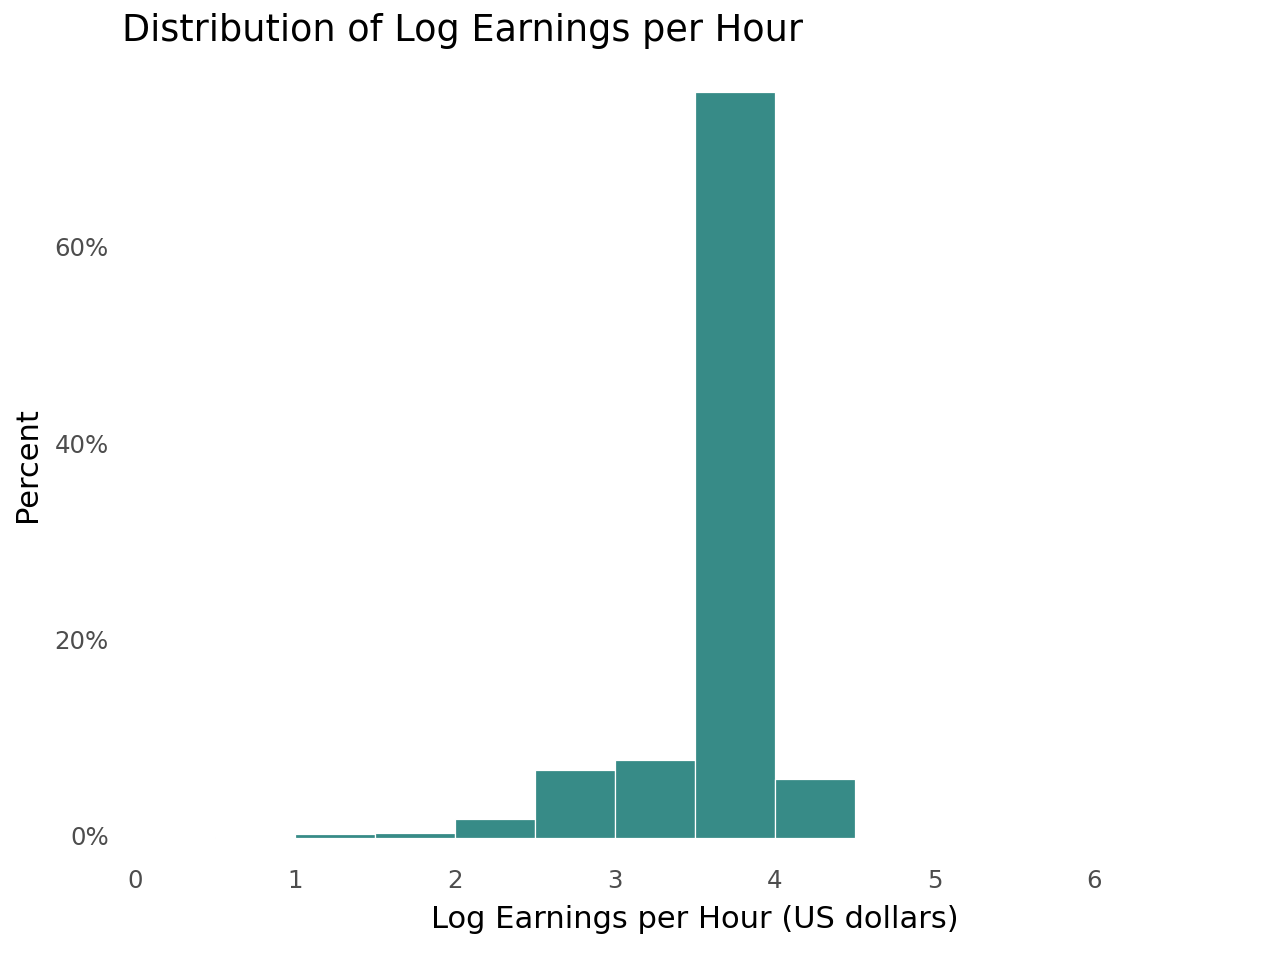

<Figure Size: (640 x 480)>

In [247]:
ggplot(df, aes(x="lneph")) + geom_histogram(
    aes(y="(stat(count))/sum(stat(count))"),
    binwidth=0.5,
    boundary=0,
    color="white",
    fill='#056F69',
    size=0.25,
    alpha=0.8,
    show_legend=False,
    na_rm=True,) \
+ coord_cartesian(xlim=(0,7)) \
+ labs(x="Log Earnings per Hour (US dollars)", y="Percent", title="Distribution of Log Earnings per Hour") \
+ theme_minimal() + expand_limits(x=0.01, y=0.01) \
+ scale_y_continuous(expand=(0.01, 0.01), labels=percent_format()) \
+ scale_x_continuous(expand=(0.01, 0.01), breaks=seq(0,7,1))\
+ theme(panel_grid_major=element_blank(), panel_grid_minor=element_blank())

In [248]:
# Checking our target variables

df['eph'].describe(percentiles= [0.25,.5,.75,.85,.90,.95])

count    9600.000000
mean       25.134289
std        19.811717
min         7.516667
25%        15.000000
50%        21.634500
75%        30.288250
85%        37.019000
90%        42.177894
95%        51.923000
max      1076.920000
Name: eph, dtype: float64

### It is clear that log earnings per hour has a better distribution (less skewed), so I will be using `eph` as my target variable instead of log, as it has a better spread of values. I am also filtering out the extreme values of eph > 54 ( ~ +1.5 std)

### Since we are considering education, I am filtering for observations that have atleast a diploma

In [249]:
df = df.loc[(df['grade92'] >= 39)] # Filtering for above 39 education level
df = df.loc[(df['eph'] <=54 )] # Filtering out extreme eph values
df.shape



(9136, 53)

### Checking relation between education level and age with earnings per hour

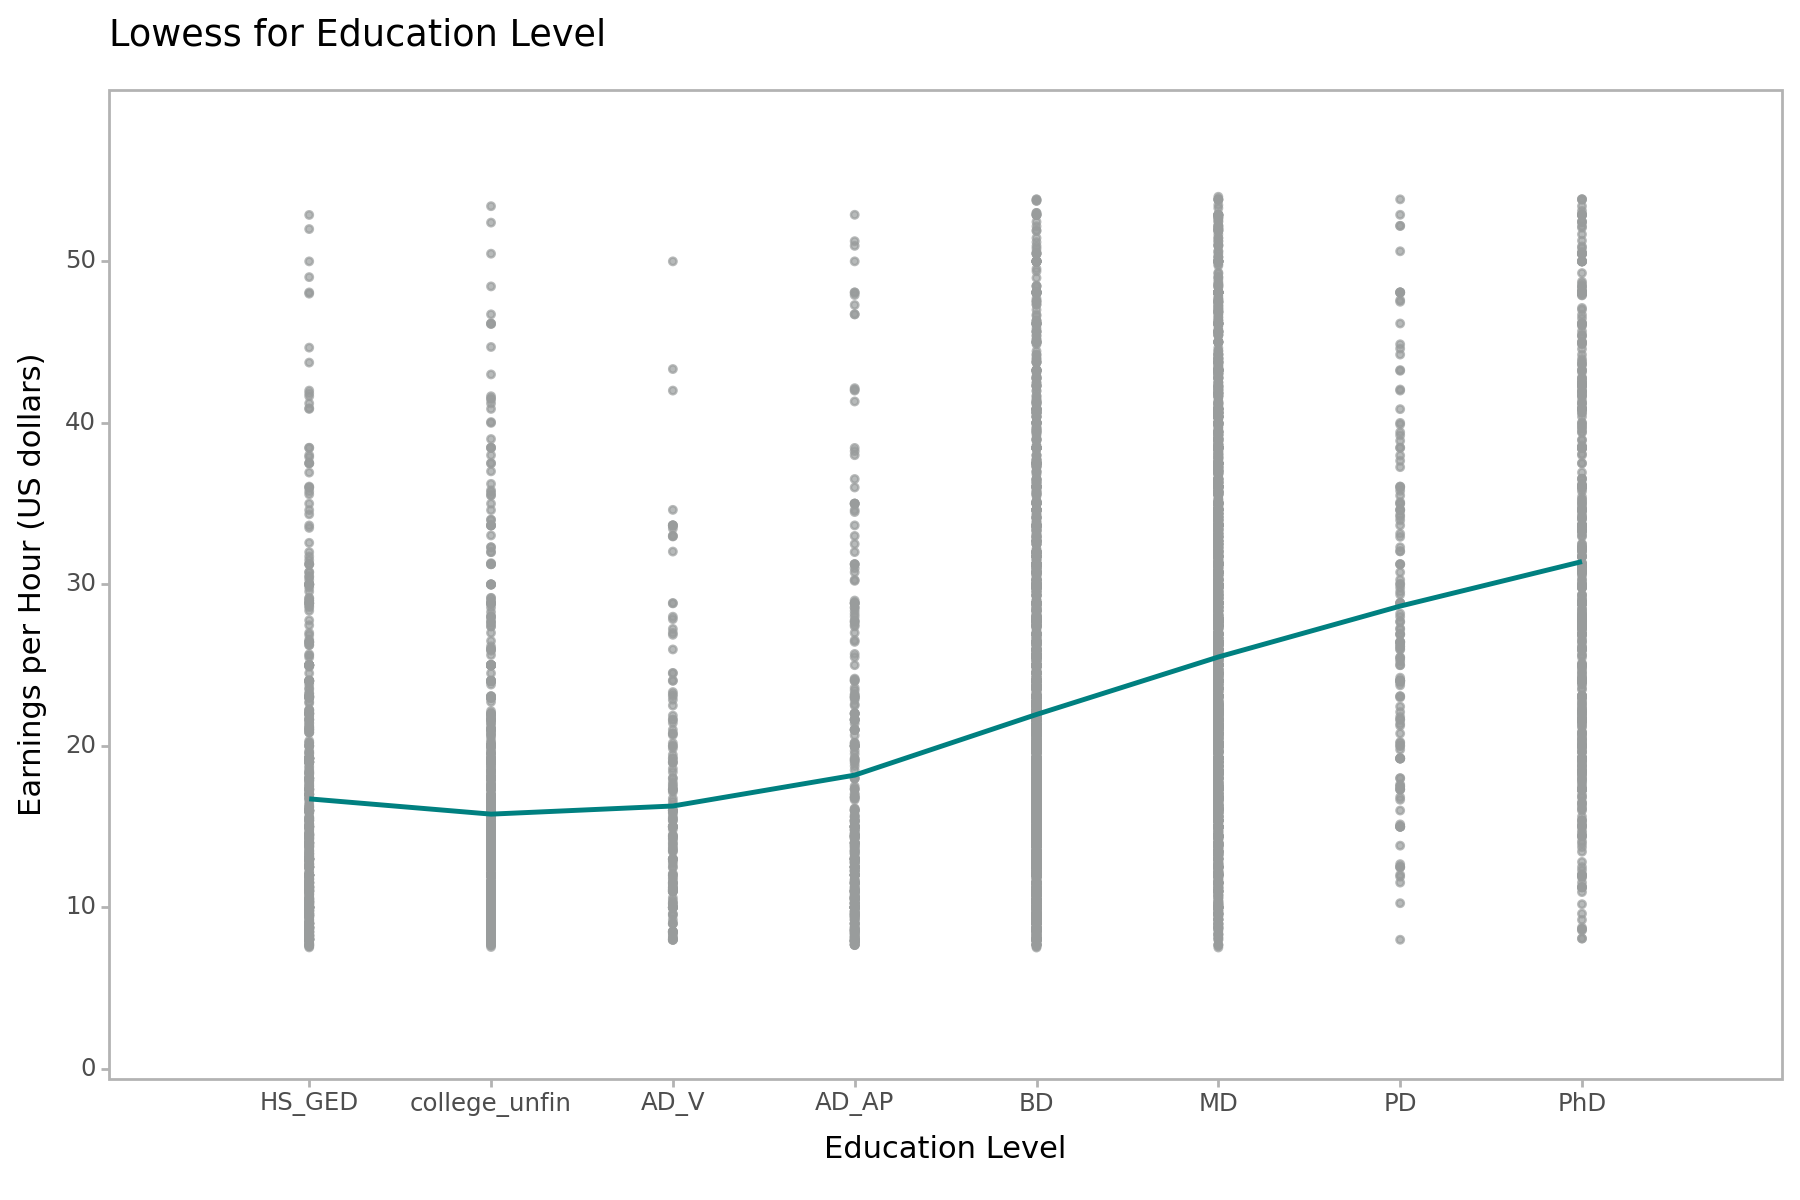

<Figure Size: (900 x 600)>

In [250]:
ggplot(df, aes(x="grade92", y="eph"))\
+ geom_point(size=1, alpha=0.7, show_legend=False, na_rm=True, fill='#999C9C', color='#999C9C')\
+ geom_smooth(method="loess", color='#008080' ,se=False, size=1, span=1) \
+ labs(x="Education Level", y="Earnings per Hour (US dollars)", title = 'Lowess for Education Level')\
+ theme_light() \
+ scale_y_continuous(expand=(0.01, 0.01), limits=(0, 60), breaks=np.arange(0, 60, 10))\
+ scale_x_continuous(expand=(0.01, 0.01), limits=(38, 47), breaks=np.arange(39, 47, 1),
                    labels=['HS_GED','college_unfin','AD_V', 'AD_AP', 'BD', 'MD', 'PD', 'PhD'])\
+ theme(panel_grid_major=element_blank(), panel_grid_minor=element_blank())\
+ theme(figure_size=(9, 6))

# Positive relationship

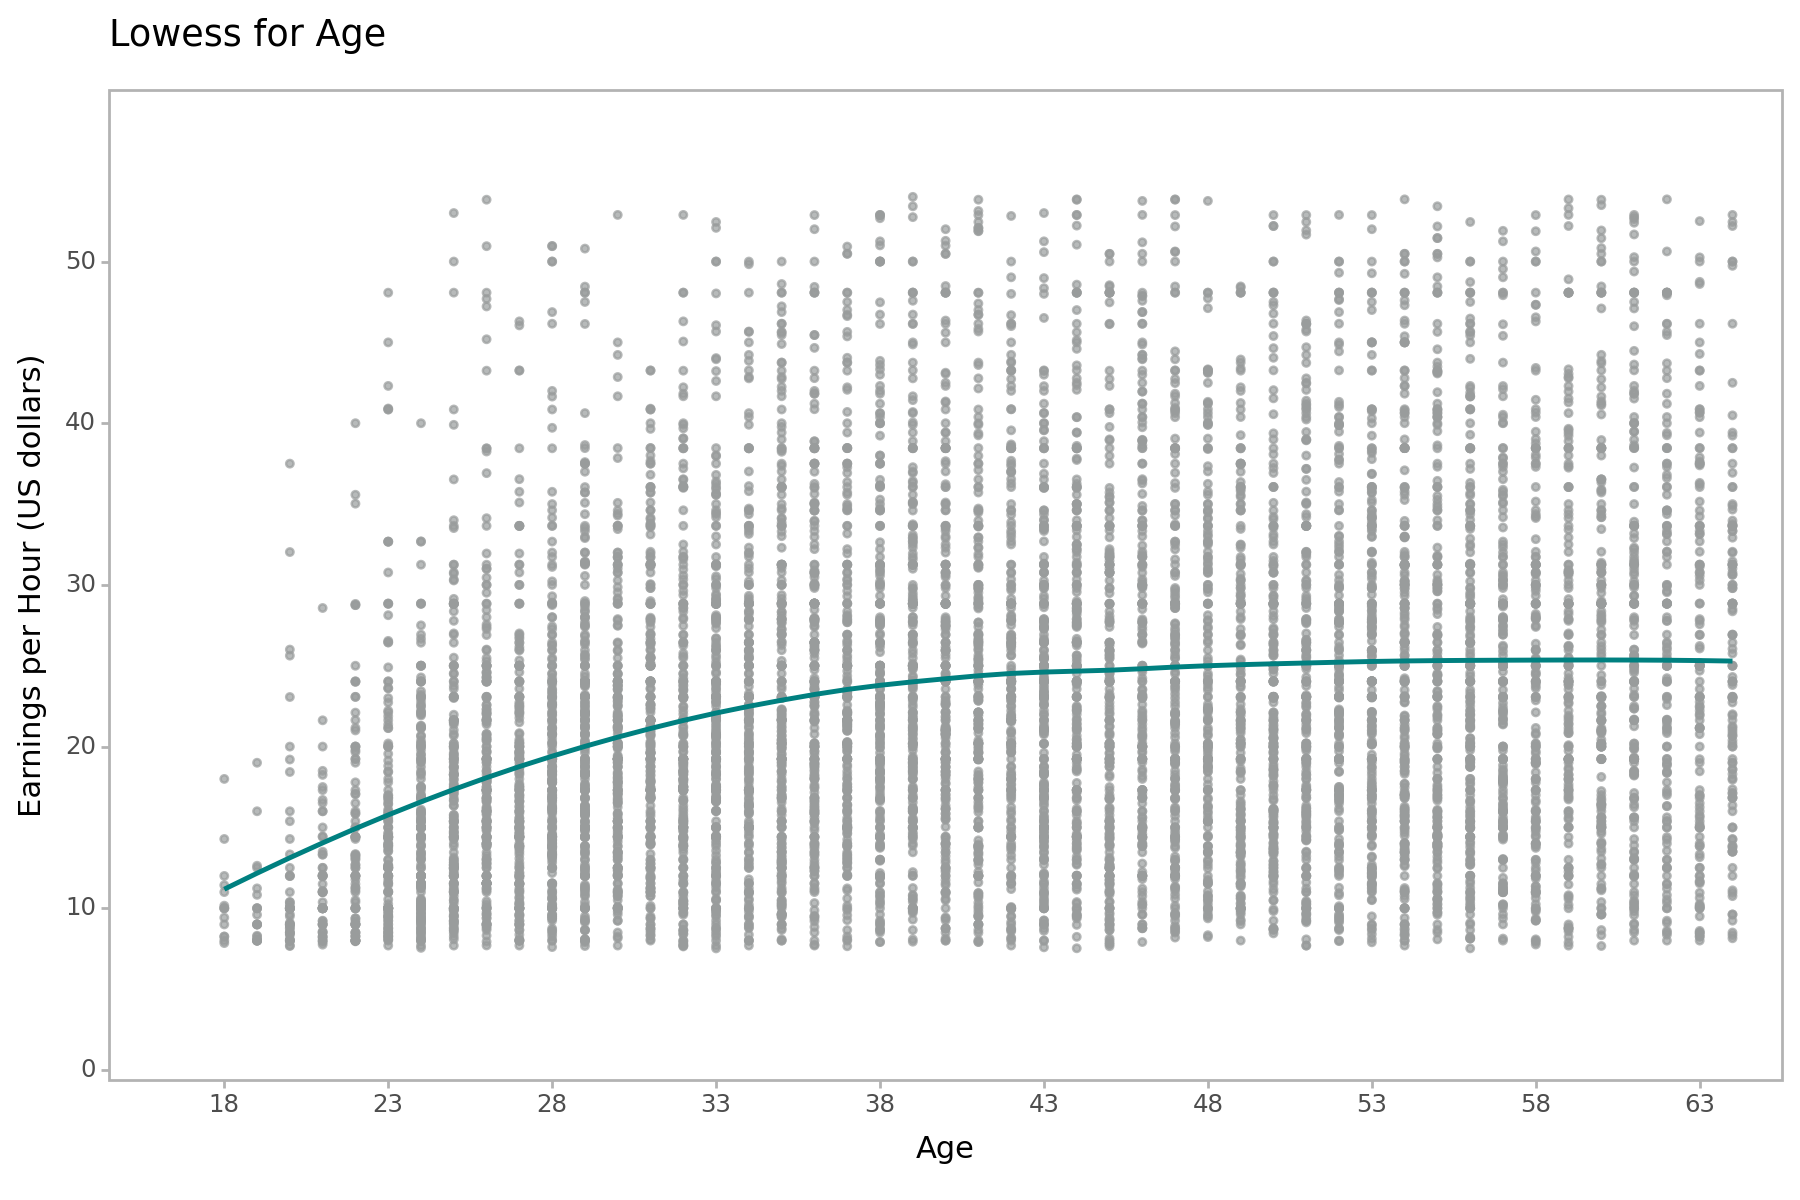

<Figure Size: (900 x 600)>

In [251]:
ggplot(df, aes(x="age", y="eph"))\
+ geom_point(size=1, alpha=0.7, show_legend=False, na_rm=True, fill='#999C9C', color='#999C9C')\
+ geom_smooth(method="loess", color='#008080' ,se=False, size=1, span=1) \
+ labs(x="Age", y="Earnings per Hour (US dollars)", title = 'Lowess for Age')\
+ theme_light() \
+ scale_y_continuous(expand=(0.01, 0.01), limits=(0, 60), breaks=np.arange(0, 60, 10))\
+ scale_x_continuous(expand=(0.01, 0.01), limits=(15, 65), breaks=np.arange(18,65, 5)) \
+ theme(panel_grid_major=element_blank(), panel_grid_minor=element_blank())\
+ theme(figure_size=(9, 6))

# Positive relationship that stagnates

In [252]:
# Dropping columns that I do not need

columns_ = ['Unnamed: 0', 'hhid', 'intmonth', 'stfips', 'weight','earnwke','uhours','grade92','race','ethnic','sex','marital'
            ,'chldpres','prcitshp','state','ind02','occ2012','class','unionmme','unioncov','lfsr94']
df.drop(columns=columns_, axis=1, inplace=True)

# 5. Models
    1. Education Level + Age
    2. Education Level + Age + Gender
    3. Education Level + Age + Gender + Marital Status + Has Children + Union
    4. Education Level + Age + Gender + Marital Status + Has Children + Union + Employment Category + Class/Sector + Race + Citizenship (Interactions)

In [253]:
# Education Level + Age
reg1 = smf.ols("eph ~ HS_GED + college_unfin + AD_V + AD_AP + BD + MD + PD + PhD + age + agesq", data=df).fit(cov_type="HC0")

# Education Level + Age + Gender
reg2 = smf.ols("eph ~ HS_GED + college_unfin + AD_V + AD_AP + BD + MD + PD + PhD + age + agesq \
                + female", data=df).fit(cov_type="HC0")

# Education Level + Age + Gender + Marital Status + Has Children + Union
reg3 = smf.ols("eph ~ HS_GED + college_unfin + AD_V + AD_AP + BD + MD + PD + PhD + age + agesq\
                + female + married + separated + never_married + ownchild + is_union_member", data=df).fit(cov_type="HC0")

# Education Level + Age + Gender + Marital Status + Has Children + Union
reg4 = smf.ols("eph ~ HS_GED + college_unfin + AD_V + AD_AP + BD + MD + PD + PhD + age + agesq\
                + female + female*age + married + separated + never_married + female*ownchild + female*is_union_member\
                + emp_work + emp_absent\
                + gov_fed_empl + gov_local_empl + gov_state_empl + priv_prof_empl + priv_nonprof_empl\
                + white_person +  non_white_person\
                + us_native + us_native_parents+ us_native_terr + age*foreign_us + age*foreign_nonus", data=df).fit(cov_type="HC0")


In [254]:
models = [reg1, reg2, reg3, reg4]
robustcov_results=[]

for i, model in enumerate(models):
    result=model.get_robustcov_results(cov_type='HC1').summary()
    robustcov_results.append(result)
    print()
    print(f'Regression: reg{i+1}')
    print(result)


Regression: reg1
                            OLS Regression Results                            
Dep. Variable:                    eph   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     5840.
Date:                Sun, 21 Jan 2024   Prob (F-statistic):               0.00
Time:                        22:31:15   Log-Likelihood:                -33210.
No. Observations:                9136   AIC:                         6.644e+04
Df Residuals:                    9126   BIC:                         6.651e+04
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.6382    

## Summaries of the models
   ###  1. Detailed Stargazer for Code

In [255]:
sg = Stargazer([reg1, reg2, reg3, reg4])

sg.custom_columns(["Model 1","Model 2", "Model 3", "Model 4"], [1, 1, 1,1])

sg.covariate_order(["Intercept","HS_GED","college_unfin","AD_V", "AD_AP", "BD", "MD", "PD", "PhD","age","agesq","female",
                           "married","separated","never_married", "ownchild", "is_union_member","emp_work","emp_absent",
                           "gov_fed_empl", "gov_local_empl" , "gov_state_empl","priv_prof_empl","priv_nonprof_empl",
                           "white_person","non_white_person","us_native", "us_native_parents","us_native_terr","foreign_us","foreign_nonus",
                           "female:age","female:ownchild","female:is_union_member","age:foreign_us","age:foreign_nonus"])

sg.rename_covariates({"Intercept":"Constant","HS_GED":"Highschool/Diploma","college_unfin":"College Unfinished",
                      "AD_V":"Assc.Degree (Vocational)","AD_AP":"Assc.Degree(Academic Program)","BD":"Bachelors Degree", 
                      "MD":"Masters Degree", "PD":"Professional Degree","PhD":"Doctoral Degree","age":"Age",
                      "agesq":"Age Squared","female":"Female","married":"Married","separated":"Separated",
                      "never_married":"Never Married","ownchild":"Has Children","is_union_member":"Union Membership",
                      "emp_work":"Employed-At Work","emp_absent":"Employed-Absent","gov_fed_empl":"Government-Federal",
                      "gov_local_empl":"Government-Local","gov_state_empl":"Government-State",
                      "priv_prof_empl":"Private-For Profit","priv_nonprof_empl":"Private-Non Profit",
                      "white_person":"White Person","non_white_person":"Colored Person","us_native":"US Native-Born in US",
                      "us_native_parents":"US Native-Parents","us_native_terr":"US Native-Territory Birth",
                      "foreign_us" :"US Foreign- Naturalization","foreign_nonus":"US Foreign-Non Citizen"})


In [256]:
rmse_values = [round(rmse(x.fittedvalues,df.eph),3) for x in [reg1,reg2,reg3,reg4]]
bic = [round(x.bic,2) for x in [reg1,reg2,reg3,reg4]]

sg.add_line('RMSE',rmse_values, location = stargazer.LineLocation.FOOTER_BOTTOM)
sg.add_line('BIC',bic, location = stargazer.LineLocation.FOOTER_BOTTOM)


In [257]:
sg

   ###  2. Simplified Stargazer for Report

In [258]:
sg = Stargazer([reg1, reg2, reg3, reg4])
sg.custom_columns(["Model 1", "Model 2", "Model 3","Model 4"], [1,1, 1, 1])
sg.covariate_order(["Intercept"])
sg.add_line("Education + Age", ["Yes", "Yes", "Yes","Yes",])
sg.add_line("Education + Age + Gender", ["","Yes", "Yes", "Yes"])
sg.add_line("Education + Age + Gender + Marital Status + Children + Union ", ["","", "Yes", "Yes"])
sg.add_line("Education + Age + Gender + Marital Status + Children + Union + Employment Category + Class/Sector + Race + Citizenship (Interactions)", ["","","","Yes"])


rmse_values = [round(rmse(x.fittedvalues,df.eph),3) for x in [reg1,reg2,reg3,reg4]]
bic = [round(x.bic,2) for x in [reg1,reg2,reg3,reg4]]
sg.add_line('RMSE',rmse_values, location = stargazer.LineLocation.FOOTER_BOTTOM)
sg.add_line('BIC',bic, location = stargazer.LineLocation.FOOTER_BOTTOM)

sg




### Cross Validation RMSE

In [259]:
from sklearn.model_selection import KFold
k = KFold(n_splits=4, shuffle=False, random_state=None)

In [260]:
### Cross validate OLS with combining sklearn k-fold cross validation and statsmodels ols formula


def cv_reg(formula, data, kfold, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]
        rmse_list += [rmse(data_train[formula.split("~")[0]], model.predict())]

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model " + str(x + 1): cvlist[x][stat] for x in range(len(cv_list))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [261]:
cv1 = cv_reg("eph~HS_GED + college_unfin + AD_V + AD_AP + BD + MD + PD + PhD + age + agesq",df, k, "HC0")

cv2 = cv_reg("eph~HS_GED + college_unfin + AD_V + AD_AP + BD + MD + PD + PhD + age + agesq + female",df, k, "HC0")

cv3 = cv_reg("eph~HS_GED + college_unfin + AD_V + AD_AP + BD + MD + PD + PhD + age + agesq\
                + female + married + separated + never_married + ownchild + is_union_member",df, k, "HC0")

cv4 = cv_reg("eph~HS_GED + college_unfin + AD_V + AD_AP + BD + MD + PD + PhD + age + agesq\
                + female + female*age + married + separated + never_married + female*ownchild + female*is_union_member\
                + emp_work + emp_absent\
                + gov_fed_empl + gov_local_empl + gov_state_empl + priv_prof_empl + priv_nonprof_empl\
                + white_person +  non_white_person\
                + us_native + us_native_parents+ us_native_terr + age*foreign_us + age*foreign_nonus",df, k, "HC0")

cv_list = [cv1, cv2, cv3, cv4]


In [262]:
summarize_cv(cv_list)

,Model 1,Model 2,Model 3,Model 4
Fold1,9.075392,9.014713,8.910633,8.867399
Fold2,9.165562,9.085607,8.989221,8.931774
Fold3,9.250644,9.175893,9.061422,9.005968
Fold4,9.191604,9.112324,9.003659,8.943017
Average,9.170801,9.097134,8.991234,8.937040


# 6. Prediction

## Using 3rd Model as the best one

### 1st Prediction

In [274]:
new_observation = pd.DataFrame(pd.Series({
    "eph":np.nan,
    "age":35,
    "agesq":35**2,
    "HS_GED": 0,                 
    "college_unfin":0,         
    "AD_V":0,                   
    "AD_AP":0,                 
    "BD":0,                     
    "MD":0,                    
    "PD":1,                    
    "PhD":0,
    "female":1,
    "married":1,                
    "separated":0,              
    "never_married":0,
    "ownchild":2,
    "emp_work":1,               
    "emp_absent":0,             
    "is_union_member":1,        
    "gov_fed_empl":0,           
    "gov_local_empl":0,         
    "gov_state_empl":0,         
    "priv_prof_empl":1,         
    "priv_nonprof_empl":0,      
    "white_person":1,           
    "non_white_person":0,       
    "us_native":1,              
    "us_native_parents":0,      
    "us_native_terr":0,         
    "foreign_us":0,             
    "foreign_nonus":0
})).T

new_observation

,eph,age,agesq,HS_GED,college_unfin,AD_V,AD_AP,BD,MD,PD,...,gov_state_empl,priv_prof_empl,priv_nonprof_empl,white_person,non_white_person,us_native,us_native_parents,us_native_terr,foreign_us,foreign_nonus
0,NaN,35.0,1225.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [275]:
# 95% PI 

p1=reg1.get_prediction(new_observation).summary_frame()
p2=reg2.get_prediction(new_observation).summary_frame()
p3=reg3.get_prediction(new_observation).summary_frame()
p4=reg4.get_prediction(new_observation).summary_frame()

result = pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(95%)", "PI_high(95%)"],
        "Model 1": p1[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model 2": p2[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model 3": p3[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model 4": p4[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],        
    }
).set_index(" ")

result['Model 3'].round(2).reset_index() # Prediction for Model 3

,,Model 3
0,Predicted,27.73
1,PI_low(95%),10.00
2,PI_high(95%),45.45


In [276]:
# Prediction Comparison between Models

result.round(2)

,Model 1,Model 2,Model 3,Model 4
,,,,
Predicted,26.95,25.76,27.73,28.22
PI_low(95%),8.88,7.83,10.00,10.57
PI_high(95%),45.02,43.69,45.45,45.87


In [277]:
# 80% PI 

p1=reg1.get_prediction(new_observation).summary_frame(alpha=0.2)
p2=reg2.get_prediction(new_observation).summary_frame(alpha=0.2)
p3=reg3.get_prediction(new_observation).summary_frame(alpha=0.2)
p4=reg4.get_prediction(new_observation).summary_frame(alpha=0.2)


result = pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(80%)", "PI_high(80%)"],
        "Model 1": p1[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model 2": p2[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model 3": p3[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model 4": p4[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],        
    }
).set_index(" ")

result['Model 3'].round(2).reset_index() # Prediction for Model 3

,,Model 3
0,Predicted,27.73
1,PI_low(80%),16.13
2,PI_high(80%),39.32


In [278]:
# Prediction Comparison between Models
result.round(2)

,Model 1,Model 2,Model 3,Model 4
,,,,
Predicted,26.95,25.76,27.73,28.22
PI_low(80%),15.14,14.04,16.13,16.68
PI_high(80%),38.77,37.48,39.32,39.76


### 2nd Prediction

In [279]:
new_observation = pd.DataFrame(pd.Series({
    "eph":np.nan,
    "age":45,
    "agesq":45**2,
    "HS_GED": 0,                 
    "college_unfin":0,         
    "AD_V":0,                   
    "AD_AP":0,                 
    "BD":0,                     
    "MD":1,                    
    "PD":0,                    
    "PhD":0,
    "female":0,
    "married":0,                
    "separated":1,              
    "never_married":0,
    "ownchild":1,
    "emp_work":1,               
    "emp_absent":0,             
    "is_union_member":1,        
    "gov_fed_empl":0,           
    "gov_local_empl":0,         
    "gov_state_empl":0,         
    "priv_prof_empl":1,         
    "priv_nonprof_empl":0,      
    "white_person":0,           
    "non_white_person":1,       
    "us_native":0,              
    "us_native_parents":1,      
    "us_native_terr":0,         
    "foreign_us":0,             
    "foreign_nonus":0
})).T

new_observation

,eph,age,agesq,HS_GED,college_unfin,AD_V,AD_AP,BD,MD,PD,...,gov_state_empl,priv_prof_empl,priv_nonprof_empl,white_person,non_white_person,us_native,us_native_parents,us_native_terr,foreign_us,foreign_nonus
0,NaN,45.0,2025.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [280]:
# 95% PI

p1=reg1.get_prediction(new_observation).summary_frame()
p2=reg2.get_prediction(new_observation).summary_frame()
p3=reg3.get_prediction(new_observation).summary_frame()
p4=reg4.get_prediction(new_observation).summary_frame()

result = pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(95%)", "PI_high(95%)"],
        "Model 1": p1[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model 2": p2[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model 3": p3[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model 4": p4[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],        
    }
).set_index(" ")

result['Model 3'].round(2).reset_index() # Prediction for Model 3

,,Model 3
0,Predicted,30.69
1,PI_low(95%),13.03
2,PI_high(95%),48.34


In [281]:
# Prediction Comparison between Models

result.round(2)

,Model 1,Model 2,Model 3,Model 4
,,,,
Predicted,27.12,29.28,30.69,31.85
PI_low(95%),9.13,11.43,13.03,14.16
PI_high(95%),45.12,47.13,48.34,49.55


In [282]:
# 80% PI 

p1=reg1.get_prediction(new_observation).summary_frame(alpha=0.2)
p2=reg2.get_prediction(new_observation).summary_frame(alpha=0.2)
p3=reg3.get_prediction(new_observation).summary_frame(alpha=0.2)
p4=reg4.get_prediction(new_observation).summary_frame(alpha=0.2)


result = pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(80%)", "PI_high(80%)"],
        "Model 1": p1[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model 2": p2[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model 3": p3[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model 4": p4[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],        
    }
).set_index(" ")

result['Model 3'].round(2).reset_index() # Prediction for Model 3

,,Model 3
0,Predicted,30.69
1,PI_low(80%),19.14
2,PI_high(80%),42.23


In [283]:
# Prediction Comparison between Models

result.round(2)

,Model 1,Model 2,Model 3,Model 4
,,,,
Predicted,27.12,29.28,30.69,31.85
PI_low(80%),15.36,17.61,19.14,20.28
PI_high(80%),38.89,40.95,42.23,43.42
